In [ ]:
import torch
from IPython.display import clear_output

major_version, minor_version = torch.cuda.get_device_capability()

if major_version >= 8:
    !pip install --no-deps "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"
else:
    !pip install --no-deps "unsloth[colab] @ git+https://github.com/unslothai/unsloth.git"

!pip install --no-deps xformers trl peft accelerate
!pip install --upgrade bitsandbytes

clear_output()
print("Unsloth and updated bitsandbytes installed successfully!")

Unsloth and updated bitsandbytes installed successfully!


In [ ]:
!pip install -q unsloth_zoo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.2/295.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.8/506.8 kB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 77.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 423.1/423.1 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.9/224.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.7/47.7 MB 15.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import re
import json
from pathlib import Path
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import numpy as np

WORK_DIR = Path("/content/training_output")
WORK_DIR.mkdir(parents=True, exist_ok=True)
POEMS_TXT = "/content/Maithili_Poem_Dataset.txt"

if hasattr(torch.cuda, '_lazy_init'):
    torch.cuda._lazy_init()

print(f"GPU: {torch.cuda.get_device_name(0)}")


GPU: Tesla T4
VRAM: 14.74 GB


In [ ]:
import unicodedata
import re
import torch
from pathlib import Path
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer_temp = AutoTokenizer.from_pretrained("unsloth/Qwen2.5-1.5B-Instruct")

def clean_text(text):
    if not text:
        return ""
    text = unicodedata.normalize('NFKC', text)

    artifacts = ['\u200b', '\ufeff', 'ï¿½', '½']
    for art in artifacts:
        text = text.replace(art, '')

    text = re.sub(r'[ \t]+', ' ', text)
    return text.strip()

def load_and_clean_poems(filepath):
    with open(filepath, "r", encoding="utf-8", errors="ignore") as f:
        raw_text = f.read()

    raw_snippets = re.split(r'\n\s*\n', raw_text)

    junk_patterns = [
        r'Upto \d+', r'Up to \d+', r'\d{4}-\d{4}',
        r'http\S+', r': मैथिली कविता'
    ]
    junk_regex = re.compile('|'.join(junk_patterns), re.IGNORECASE)

    cleaned_data = []
    for snippet in raw_snippets:
        clean_snippet = clean_text(snippet)

        if len(clean_snippet) < 30: # Skipping very short snippets
            continue
        if junk_regex.search(clean_snippet):
            continue

        cleaned_data.append({"text": clean_snippet})

    return cleaned_data

def format_as_instructions(data, tokenizer):
    alpaca_template = """Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
Write or complete the following text in Maithili.

### Input:
{title}

### Response:
{body}"""

    formatted = []
    for item in data:
        full_text = item['text']
        lines = full_text.split('\n')

        if len(lines) > 1:
            title = lines[0].strip()
            body = "\n".join(lines[1:]).strip()
        else:
            title = "Maithili Literature"
            body = full_text

        if len(body) < 10:
            continue

        text = alpaca_template.format(title=title, body=body)
        text += tokenizer.eos_token
        formatted.append({"text": text})

    return formatted


processed_snippets = load_and_clean_poems(POEMS_TXT)
formatted_data = format_as_instructions(processed_snippets, tokenizer_temp)

# Create train/val split
full_dataset = Dataset.from_list(formatted_data)
dataset_dict = full_dataset.train_test_split(test_size=0.05, seed=42)
train_dataset = dataset_dict["train"]
eval_dataset = dataset_dict["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(eval_dataset)}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

Training samples: 1269
Validation samples: 67


In [ ]:
from unsloth import FastLanguageModel
from trl import SFTTrainer
from transformers import TrainingArguments, EarlyStoppingCallback

# Load model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Qwen2.5-1.5B-Instruct",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)


model = FastLanguageModel.get_peft_model(
    model,
    r=16,                # INCREASED from 8: Higher capacity to distinguish Maithili from Hindi
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj",
                    "gate_proj", "up_proj", "down_proj"],
    lora_alpha=32,       # INCREASED from 8: Stronger influence of the new training data
    lora_dropout=0.05,   # REDUCED from 0.1: Less noise during training
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

# Training arguments
training_args = TrainingArguments(
    output_dir=str(WORK_DIR),
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    warmup_steps=40,
    max_steps=400,
    learning_rate=1e-5,
    fp16=not torch.cuda.is_bf16_supported(),
    bf16=torch.cuda.is_bf16_supported(),
    logging_steps=10,
    eval_strategy="steps",
    eval_steps=40,
    save_strategy="steps",
    save_steps=40,
    save_total_limit=2,
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    optim="adamw_8bit",
    weight_decay=0.05,
    lr_scheduler_type="cosine",
    seed=3407,
    report_to="none",
)

# Trainer
trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    dataset_num_proc=2,
    packing=True,
    args=training_args,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting training with optimized parameters...")
trainer_stats = trainer.train()
print("Training complete!")

/tmp/ipython-input-3641600390.py:1: UserWarning: WARNING: Unsloth should be imported before [transformers] to ensure all optimizations are applied. Your code may run slower or encounter memory issues without these optimizations.

Please restructure your imports with 'import unsloth' at the top of your file.
  from unsloth import FastLanguageModel


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.1.1: Fast Qwen2 patching. Transformers: 4.57.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu126. CUDA: 7.5. CUDA Toolkit: 12.6. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post2. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.53G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/605 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2026.1.1 patched 28 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/1269 [00:00<?, ? examples/s]

Unsloth: Tokenizing ["text"] (num_proc=4):   0%|          | 0/67 [00:00<?, ? examples/s]

The model is already on multiple devices. Skipping the move to device specified in `args`.


Starting training with optimized parameters...


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 1,269 | Num Epochs = 5 | Total steps = 400
O^O/ \_/ \    Batch size per device = 4 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (4 x 4 x 1) = 16
 "-____-"     Trainable parameters = 18,464,768 of 1,562,179,072 (1.18% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
40,2.274300,2.333045
80,2.034400,2.143744
120,2.012100,2.079805
160,1.971000,2.037508
200,1.948600,2.006632
240,1.854700,1.984203
280,1.826600,1.969612
320,1.895100,1.962885
360,1.906200,1.960061
400,1.872700,1.959577


Unsloth: Not an error, but Qwen2ForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient


Training complete!


In [ ]:
import torch
from math import exp
import numpy as np

def calculate_metrics(model, tokenizer, text):
    inputs = tokenizer(text, return_tensors="pt").to("cuda")
    with torch.no_grad():
        outputs = model(**inputs, labels=inputs["input_ids"])
        loss = outputs.loss.item()

    perplexity = exp(loss)

    tokens = tokenizer.tokenize(text)
    types = set(tokens)
    ttr = len(types) / len(tokens) if len(tokens) > 0 else 0

    return perplexity, ttr

def generate_maithili_text(model, tokenizer, title, max_new_tokens=128):
    prompt = f"""Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
Write or complete the following text in Maithili.

### Input:
{title}

### Response:
"""
    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        repetition_penalty=1.1, # Prevents looping on the same Maithili phrases
        use_cache=True
    )

    generated_text = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]

    response = generated_text.split("### Response:")[-1].strip()
    return response

#Test Inference
FastLanguageModel.for_inference(model)

test_titles = ["मिथिलाक संस्कृति", "बिहनि", "गामक साझ"]

print(f"{'Title':<20} | {'PPL (Lower=Better)':<18} | {'TTR (Diversity)':<15}")
print("-" * 60)

for title in test_titles:
    output = generate_maithili_text(model, tokenizer, title)
    ppl, ttr = calculate_metrics(model, tokenizer, output)

    print(f"{title:<20} | {ppl:<18.2f} | {ttr:<15.2f}")
    print(f"Generated Text:\n{output}\n")
    print("="*60)

Title                | PPL (Lower=Better) | TTR (Diversity)
------------------------------------------------------------
मिथिलाक संस्कृति     | 8.17               | 0.55           
Generated Text:
प्रेतापुर के अन्दर मिन्ह पहला
देशक बैठछि रहबौ भीन आइया
दोषक जल के गाँव धुआ घर डिम डूँ चढ़ता
हम उपचार खेलबौ ओडियाँ छाटबौ
अछि कटक

बिहनि                | 8.30               | 0.54           
Generated Text:
मर्त्यो जीवन ने आइयो
काँपल कहैत दुःख बहार होइयो
सजल माथा उछल छल खेलन विश्व
भटकबूझ एक गोला देण भेटी छी
आइ अछि संगीत फ़्लौट जल
ता�

गामक साझ             | 7.42               | 0.54           
Generated Text:
हिंसक रोजने कैबरमुखी
देवता के लेखिक दिन
लंघन हम अपनी मुहाय
अवधि भोजन गेले बातमय
देहरा पर जुगुआ कथासँ
चरण पड़ गेले आकाश
भय किछु उठल्ला



In [ ]:
import math
from collections import Counter

def calculate_perplexity(model, tokenizer, texts, max_samples=20):
    model.eval()
    nlls = []

    for text in texts[:max_samples]:
        inputs = tokenizer(text, return_tensors="pt").to(model.device)
        with torch.no_grad():
            outputs = model(inputs.input_ids, labels=inputs.input_ids)
            nlls.append(outputs.loss)

    perplexity = torch.exp(torch.stack(nlls).mean())
    return perplexity.item()

def calculate_ttr(text):
    tokens = text.split()
    if len(tokens) == 0:
        return 0.0
    unique_tokens = len(set(tokens))
    return unique_tokens / len(tokens)

def calculate_rhyme_density(poem):
    """Estimate rhyme density by checking line endings."""
    lines = [line.strip() for line in poem.split('\n') if line.strip()]
    if len(lines) < 2:
        return 0.0

    endings = [line[-2:] if len(line) >= 2 else line for line in lines]
    ending_counts = Counter(endings)

    rhyming_lines = sum(1 for count in ending_counts.values() if count > 1)
    return rhyming_lines / len(lines)

def calculate_meter_consistency(poem):
    lines = [line.strip() for line in poem.split('\n') if line.strip()]
    if len(lines) < 2:
        return 0.0

    syllable_counts = [len(line.split()) for line in lines]
    if not syllable_counts:
        return 0.0

    mean_syllables = np.mean(syllable_counts)
    std_syllables = np.std(syllable_counts)

    cv = std_syllables / mean_syllables if mean_syllables > 0 else 1.0
    consistency = max(0, 1 - cv)
    return consistency

def evaluate_model(model, tokenizer, eval_texts, generated_poem):
    ppl = calculate_perplexity(model, tokenizer, eval_texts)
    ttr = calculate_ttr(generated_poem)
    rhyme = calculate_rhyme_density(generated_poem)
    meter = calculate_meter_consistency(generated_poem)

    return {
        "perplexity": ppl,
        "ttr": ttr,
        "rhyme_density": rhyme,
        "meter_consistency": meter
    }

In [ ]:

from unsloth import FastLanguageModel


FastLanguageModel.for_inference(model)

def generate_poem(title, model, tokenizer):
    prompt = f"""Below is an instruction that describes a task.
Write a response that appropriately completes the request.

### Instruction:
Write a Maithili poem based on the following title or theme.

### Input:
{title}

### Response:
"""

    inputs = tokenizer([prompt], return_tensors="pt").to("cuda")
    outputs = model.generate(
        **inputs,
        max_new_tokens=200,
        use_cache=True,
        temperature=0.5,
        repetition_penalty=1.2,
        no_repeat_ngram_size=3,
        top_k=40,
        top_p=0.9
    )

    result = tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
    poem = result.split("### Response:")[-1].strip()
    return clean_text(poem) # Using your clean_text from CELL-3

test_titles = [
    "मिथिलाक वर्णन",
    "युद्ध",
    "प्रेम"
]

all_metrics = []
eval_texts = [item['text'] for item in eval_dataset]

print(f"{'Title':<20} | {'Perplexity':<10}")
print("-" * 35)

for title in test_titles:
    generated_poem = generate_poem(title, model, tokenizer)

    metrics = evaluate_model(model, tokenizer, eval_texts, generated_poem)
    metrics['title'] = title
    all_metrics.append(metrics)

    print(f"\nTitle: {title}")
    print("-" * 20)
    print(generated_poem)
    print("=" * 60)

avg_ppl = np.mean([m['perplexity'] for m in all_metrics])
print(f"\nAVERAGE PERPLEXITY ACROSS SAMPLES: {avg_ppl:.2f}")

Title                | Perplexity
-----------------------------------

Title: मिथिलाक वर्णन
Perplexity: 6.33
--------------------
सुंदर मैथिलीक होला
गेंचि सज़े कहत नहि प्रभु
पशु जय रखब मृत्यु
आइए अछि आइए सवामी
अधिपति कोटि गीत
डुढऽ बन्दर भरि एउठा
जय मौर्तिहुष्टा छी धर्शिया
हमरा उत्सुक चण्डिय घर
हरियो फूफू खेलबै इतिहास
बन्धुक समाज ओझ

Title: युद्ध
Perplexity: 6.33
--------------------
प्रभावक देश के पूरा महिला समस्या
अन्तःखंड नगली होइत अछि रहब
ज्ञापणी आशा, ज्ञा-आशा बढ़ियो!
एव्ह! सच्चाई सुधाकर भाषा छी गई
हम खट्टा उठा फुला डाम ढाइत
झोड़ी घोषी ठोरा झाँउओ
फोलो ओ मिथिली मौसमन एही छोटी
सिसरा हम

Title: प्रेम
Perplexity: 6.33
--------------------
अछि निर्वाण
मेरा सुंदर मूलक होही कयब
सँग पड़ती हुनुआइए दुख
जाइए जाहि तोहि बचाय गई
झर आइए हटाए छी चढऽ भास्कर
विश्व-भाषण अधिपति लगाउथि ओहि
अछिथि खरीदैत धीरे घृणा
शिफ्टे ठाड़ि झुकौओ ऊठा
मूळ दिन और अछि

AVERAGE PERPLEXITY ACROSS SAMPLES: 6.33


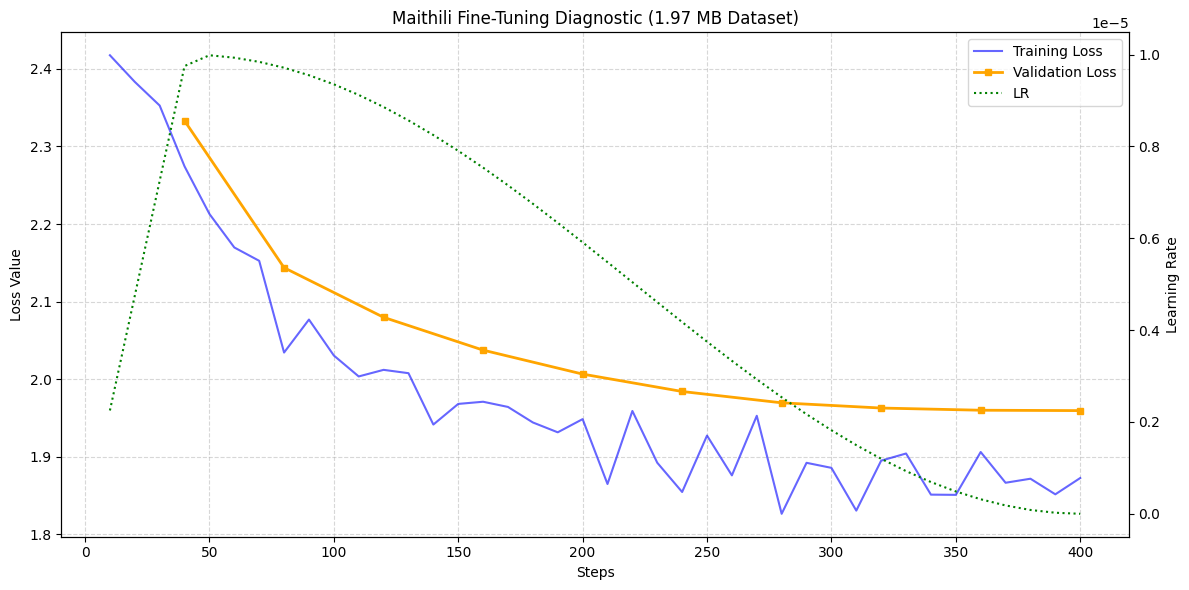

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_curves(log_history):
    train_steps = []
    train_losses = []
    eval_steps = []
    eval_losses = []
    learning_rates = []

    for entry in log_history:
        if 'loss' in entry:
            train_steps.append(entry['step'])
            train_losses.append(entry['loss'])
            if 'learning_rate' in entry:
                learning_rates.append(entry['learning_rate'])
        if 'eval_loss' in entry:
            eval_steps.append(entry['step'])
            eval_losses.append(entry['eval_loss'])

    fig, ax1 = plt.subplots(figsize=(12, 6))

    ax1.plot(train_steps, train_losses, label='Training Loss', color='blue', alpha=0.6, linewidth=1.5)
    if eval_steps:
        ax1.plot(eval_steps, eval_losses, label='Validation Loss', color='orange', marker='s', markersize=4, linewidth=2)

    ax1.set_xlabel('Steps')
    ax1.set_ylabel('Loss Value')
    ax1.set_title('Maithili Fine-Tuning Diagnostic (1.97 MB Dataset)')
    ax1.grid(True, linestyle='--', alpha=0.5)

    ax2 = ax1.twinx()
    if learning_rates:
        ax2.plot(train_steps[:len(learning_rates)], learning_rates, color='green', linestyle=':', label='LR')
        ax2.set_ylabel('Learning Rate')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper right')

    plt.tight_layout()
    plt.savefig(str(WORK_DIR / 'loss_diagnostic.png'), dpi=150)
    plt.show()

plot_training_curves(trainer.state.log_history)

In [ ]:

import json
from google.colab import files

filename = "gemma_2B_2_0.ipynb"

with open(filename, "r", encoding="utf-8") as f:
    nb = json.load(f)

nb.get("metadata", {}).pop("widgets", None)

with open(filename, "w", encoding="utf-8") as f:
    json.dump(nb, f, ensure_ascii=False, indent=2)

files.download(filename)